<a href="https://colab.research.google.com/github/Ronshin-Vsevolod/Comparison-of-optimizers/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.9 MB/s eta 0:00:00
Using: cuda


100%|██████████| 170M/170M [00:05<00:00, 28.9MB/s]



==== ARCHITECTURE: SIMPLECNN ====
Using ADAM with learning rate = 0.001


W0730 14:01:22.559000 331 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


[ADAM][Epoch 1] Train Loss: 1.6434, Train Acc: 39.28%
[ADAM][Epoch 2] Train Loss: 1.3628, Train Acc: 49.86%
[ADAM][Epoch 3] Train Loss: 1.2595, Train Acc: 54.06%
[ADAM][Epoch 4] Train Loss: 1.1954, Train Acc: 56.07%
[ADAM][Epoch 5] Train Loss: 1.1512, Train Acc: 58.06%
[ADAM][Epoch 6] Train Loss: 1.1166, Train Acc: 58.95%
[ADAM][Epoch 7] Train Loss: 1.0879, Train Acc: 60.24%
[ADAM][Epoch 8] Train Loss: 1.0568, Train Acc: 61.32%
[ADAM][Epoch 9] Train Loss: 1.0265, Train Acc: 62.38%
[ADAM][Epoch 10] Train Loss: 0.9928, Train Acc: 63.85%
[ADAM][Epoch 11] Train Loss: 0.9791, Train Acc: 63.98%
[ADAM][Epoch 12] Train Loss: 0.9505, Train Acc: 65.16%
[ADAM][Epoch 13] Train Loss: 0.9361, Train Acc: 65.79%
[ADAM][Epoch 14] Train Loss: 0.9145, Train Acc: 66.42%
[ADAM][Epoch 15] Train Loss: 0.8981, Train Acc: 66.86%
[ADAM][Epoch 16] Train Loss: 0.8770, Train Acc: 67.79%
[ADAM][Epoch 17] Train Loss: 0.8568, Train Acc: 68.21%
[ADAM][Epoch 18] Train Loss: 0.8475, Train Acc: 68.45%
[ADAM][Epoch 19] Tr

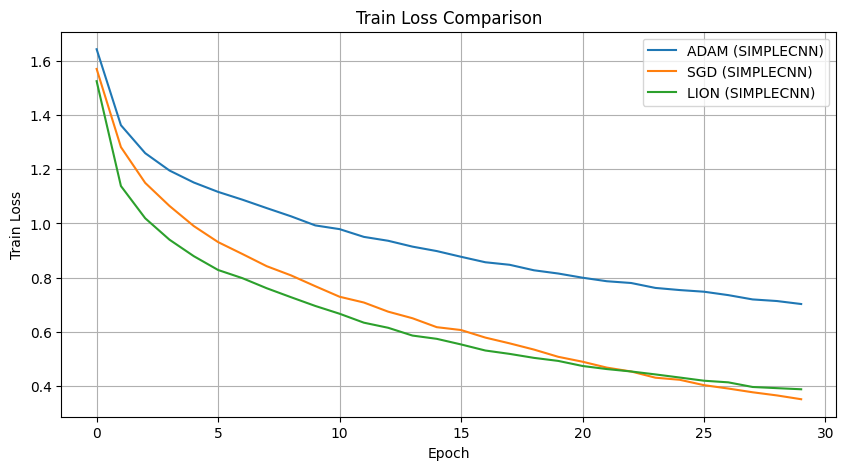

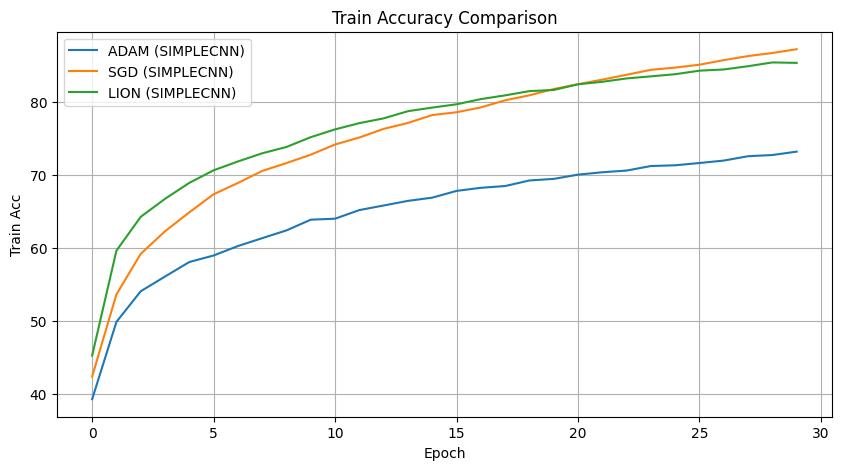

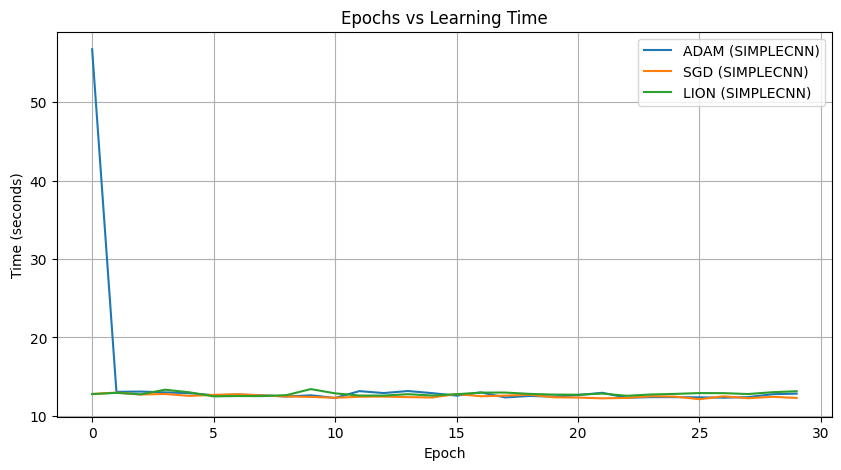

ADAM (SIMPLECNN) - Final Test Loss: 0.7892, Test Accuracy: 74.26%, Epochs to reach 70% acc: 21
SGD (SIMPLECNN) - Final Test Loss: 0.8662, Test Accuracy: 74.91%, Epochs to reach 70% acc: 8
LION (SIMPLECNN) - Final Test Loss: 0.9438, Test Accuracy: 74.17%, Epochs to reach 70% acc: 6
Epochs to reach 70% train accuracy:
ADAM (RESNET): reached in 2 epochs
SGD (RESNET): reached in 3 epochs
LION (RESNET): reached in 2 epochs


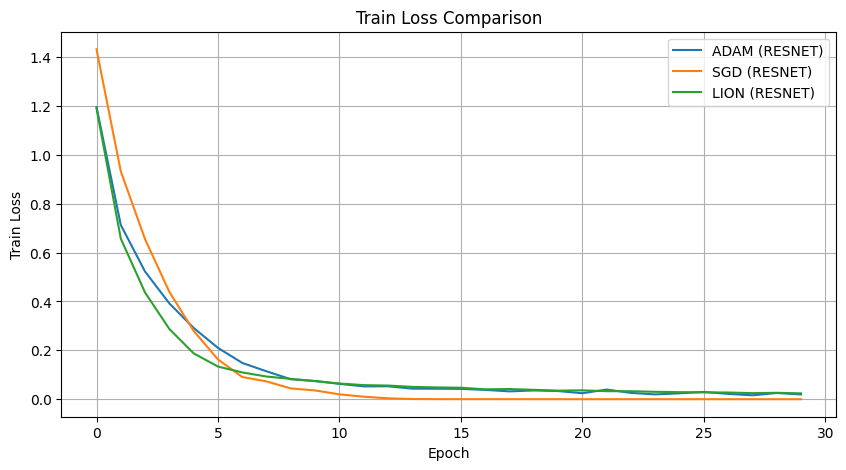

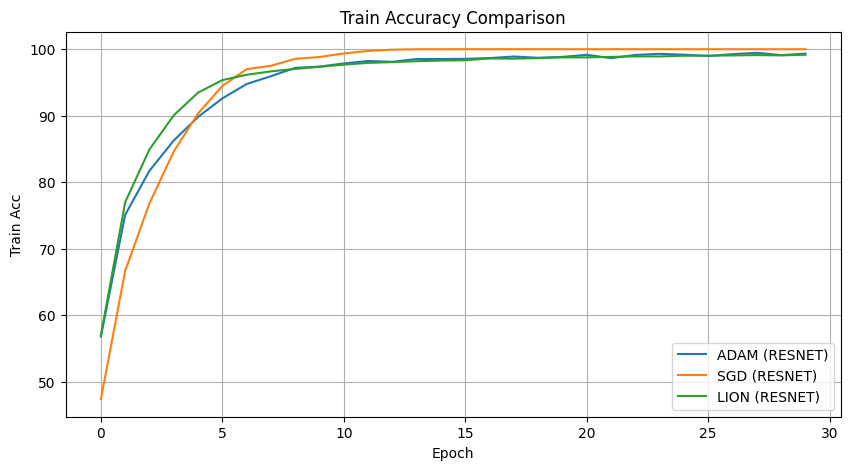

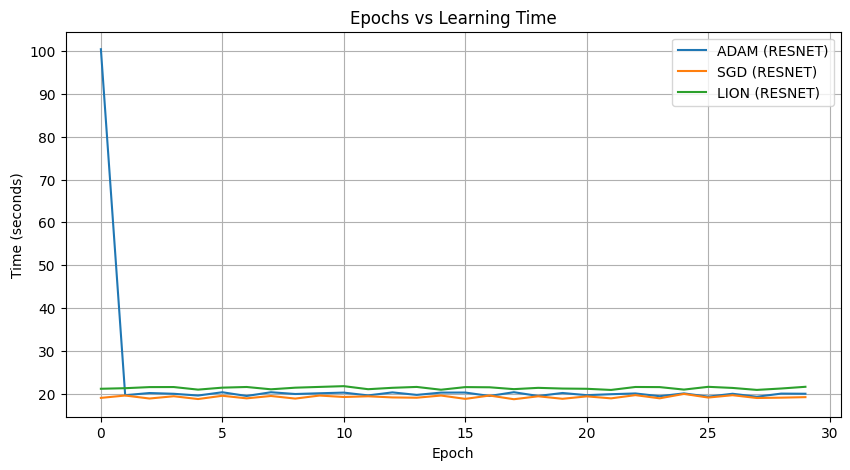

ADAM (RESNET) - Final Test Loss: 0.8934, Test Accuracy: 84.02%, Epochs to reach 70% acc: 2
SGD (RESNET) - Final Test Loss: 1.0590, Test Accuracy: 79.81%, Epochs to reach 70% acc: 3
LION (RESNET) - Final Test Loss: 0.9086, Test Accuracy: 83.73%, Epochs to reach 70% acc: 2
--- ADAM (SIMPLECNN) Summary ---
Final Test Accuracy: 74.26%
Epoch to reach 70.0% accuracy: 21
Training time (seconds): 433.92
Final Test Accuracy: 74.26%
--- ADAM (RESNET) Summary ---
Final Test Accuracy: 84.02%
Epoch to reach 70.0% accuracy: 2
Training time (seconds): 691.00
Final Test Accuracy: 84.02%
--- SGD (SIMPLECNN) Summary ---
Final Test Accuracy: 74.91%
Epoch to reach 70.0% accuracy: 8
Training time (seconds): 378.56
Final Test Accuracy: 74.91%
--- SGD (RESNET) Summary ---
Final Test Accuracy: 79.81%
Epoch to reach 70.0% accuracy: 3
Training time (seconds): 579.50
Final Test Accuracy: 79.81%
--- LION (SIMPLECNN) Summary ---
Final Test Accuracy: 74.17%
Epoch to reach 70.0% accuracy: 6
Training time (seconds): 

,Epoch,Optimizer,Train Accuracy,Train Loss
0,10,Adam,63.85%,0.9928
1,20,Adam,69.43%,0.8152
2,30,Adam,73.16%,0.7026
3,10,SGD,72.74%,0.7684
4,20,SGD,81.73%,0.5077
5,30,SGD,87.17%,0.3511
6,10,Lion,75.14%,0.6955
7,20,Lion,81.60%,0.4926
8,30,Lion,85.30%,0.3879


,Model (Opt),Time (s),Epochs to 70%,Final Acc (%),Final Loss,Loss Std (Last 5)
0,SimpleCNN (Adam),433.9,21,74.26,0.7892,0.0161
1,SimpleCNN (SGD),378.6,8,74.91,0.8662,0.0183
2,SimpleCNN (Lion),387.4,6,74.17,0.9438,0.0124
3,ResNet18 (Adam),691.0,2,84.02,0.8934,0.0047
4,ResNet18 (SGD),579.5,3,79.81,1.0590,0.0000
5,ResNet18 (Lion),642.3,2,83.73,0.9086,0.0015


KeyError: 'Val Acc'

In [1]:
!pip install -q lion-pytorch

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from lion_pytorch import Lion
import matplotlib.pyplot as plt
import time
import pandas as pd
from IPython.display import display
from torch.amp import autocast, GradScaler
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=100,
                        shuffle=False, num_workers=2)



class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(8*8*64, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


def train_and_evaluate(optimizer_name, num_epochs, target_acc, train_loader, val_loader,
                       model_name, use_amp=True, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):

    if model_name == "simplecnn":
        model = SimpleCNN()
    elif model_name == "resnet18":
        model = resnet18(weights=None)
        model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        model.maxpool = nn.Identity()
        model.fc = nn.Linear(model.fc.in_features, 10)
    else:
        raise ValueError(f"Unknown model name: {model_name}")

    model = torch.compile(model)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    scheduler = None

    if optimizer_name == "adam":
        lr = 0.001
        optimizer = optim.Adam(model.parameters(), lr=lr)

    elif optimizer_name == "sgd":
        lr = 0.01
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    elif optimizer_name == "lion":
        lr = 1e-4
        optimizer = Lion(
            model.parameters(),
            lr=lr,
            betas=(0.9, 0.99),
            weight_decay=0.0,
            decoupled_weight_decay=False
        )

    else:
        raise ValueError("Unknown optimizer")

    print(f"Using {optimizer_name.upper()} with learning rate = {lr}")

    train_loss_list, train_acc_list = [], []
    epoch_times = []
    epoch_to_target_acc = None

    if use_amp and device.type == "cuda":
        scaler = torch.amp.GradScaler()
    else:
        scaler = None

    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            if use_amp and device.type == "cuda":
                with torch.amp.autocast(device_type="cuda", enabled=use_amp):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            if scheduler:
              scheduler.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)

        epoch_times.append(time.time() - start_time)

        if epoch_to_target_acc is None and train_acc >= target_acc:
            epoch_to_target_acc = epoch + 1

        print(f"[{optimizer_name.upper()}][Epoch {epoch+1}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    test_loss /= len(testloader)
    test_acc = 100 * correct / total

    print(f"\n[{optimizer_name.upper()}] FINAL TEST RESULTS - Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")
    if epoch_to_target_acc:
        print(f"Epochs to reach {target_acc}% accuracy: {epoch_to_target_acc}")
    else:
        print(f"Did not reach {target_acc}% accuracy in {num_epochs} epochs")

    return {
        "train_loss": train_loss_list,
        "train_acc": train_acc_list,
        "epoch_times": epoch_times,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "epochs_to_target_acc": epoch_to_target_acc or num_epochs
    }


def train_and_time(optimizer_name, num_epochs=30, target_acc=70.0, model_name="simplecnn"):
    start_time = time.time()
    results = train_and_evaluate(
        optimizer_name,
        num_epochs=num_epochs,
        target_acc=target_acc,
        train_loader=trainloader,
        val_loader=testloader,
        model_name=model_name
    )
    elapsed = time.time() - start_time
    return results, elapsed


def plot_metric(metric_name, results_dict, title):
    plt.figure(figsize=(10, 5))
    for name, result in results_dict.items():
        plt.plot(result[metric_name], label=name.upper())
    plt.xlabel("Epoch")
    plt.ylabel(metric_name.replace("_", " ").title())
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_times(results_dict):
    plt.figure(figsize=(10, 5))
    for name, result in results_dict.items():
        plt.plot(result["epoch_times"], label=name.upper())
    plt.xlabel("Epoch")
    plt.ylabel("Time (seconds)")
    plt.title("Epochs vs Learning Time")
    plt.legend()
    plt.grid(True)
    plt.show()

print("\n==== ARCHITECTURE: SIMPLECNN ====")
results_adam, time_adam = train_and_time("adam", num_epochs=30, model_name="simplecnn")
results_sgd, time_sgd = train_and_time("sgd", num_epochs=30, model_name="simplecnn")
results_lion, time_lion = train_and_time("lion", num_epochs=30, model_name="simplecnn")

print("\n==== ARCHITECTURE: RESNET18 ====")
results_resnet_adam, time_resnet_adam = train_and_time("adam", num_epochs=30, model_name="resnet18")
results_resnet_sgd, time_resnet_sgd = train_and_time("sgd", num_epochs=30, model_name="resnet18")
results_resnet_lion, time_resnet_lion = train_and_time("lion", num_epochs=30, model_name="resnet18")

def epochs_to_threshold(results, threshold=70.0):
    for epoch, acc in enumerate(results["train_acc"]):
        if acc >= threshold:
            return epoch + 1
    return None

all_results_simplecnn = {
    "adam (SimpleCNN)": results_adam,
    "sgd (SimpleCNN)": results_sgd,
    "lion (SimpleCNN)": results_lion
}
all_results_resnet = {
    "adam (ResNet)": results_resnet_adam,
    "sgd (ResNet)": results_resnet_sgd,
    "lion (ResNet)": results_resnet_lion
}


print("Epochs to reach 70% train accuracy:")
for name, res in all_results_simplecnn.items():
    ep = epochs_to_threshold(res, threshold=70.0)
    if ep:
        print(f"{name.upper()}: reached in {ep} epochs")
    else:
        print(f"{name.upper()}: not reached")

plot_metric("train_loss", all_results_simplecnn, "Train Loss Comparison")
plot_metric("train_acc", all_results_simplecnn, "Train Accuracy Comparison")
plot_times(all_results_simplecnn)
for name, res in all_results_simplecnn.items():
    print(f"{name.upper()} - Final Test Loss: {res['test_loss']:.4f}, Test Accuracy: {res['test_acc']:.2f}%, "
          f"Epochs to reach 70% acc: {res['epochs_to_target_acc']}")


print("Epochs to reach 70% train accuracy:")
for name, res in all_results_resnet.items():
    ep = epochs_to_threshold(res, threshold=70.0)
    if ep:
        print(f"{name.upper()}: reached in {ep} epochs")
    else:
        print(f"{name.upper()}: not reached")

plot_metric("train_loss", all_results_resnet, "Train Loss Comparison")
plot_metric("train_acc", all_results_resnet, "Train Accuracy Comparison")
plot_times(all_results_resnet)
for name, res in all_results_resnet.items():
    print(f"{name.upper()} - Final Test Loss: {res['test_loss']:.4f}, Test Accuracy: {res['test_acc']:.2f}%, "
          f"Epochs to reach 70% acc: {res['epochs_to_target_acc']}")


def print_summary(optimizer_name, results, training_time, threshold=70.0):
    print(f"--- {optimizer_name.upper()} Summary ---")
    final_acc = results['test_acc']
    epoch_thresh = epochs_to_threshold(results, threshold)
    print(f"Final Test Accuracy: {final_acc:.2f}%")
    if epoch_thresh is not None:
        print(f"Epoch to reach {threshold}% accuracy: {epoch_thresh}")
    else:
        print(f"Did NOT reach {threshold}% accuracy in {len(results['test_acc'])} epochs")
    print(f"Training time (seconds): {training_time:.2f}")
    print(f"Final Test Accuracy: {results['test_acc']:.2f}%")

print_summary("adam (SimpleCNN)", results_adam, time_adam)
print_summary("adam (ResNet)", results_resnet_adam, time_resnet_adam)
print_summary("sgd (SimpleCNN)", results_sgd, time_sgd)
print_summary("sgd (ResNet)", results_resnet_sgd, time_resnet_sgd)
print_summary("lion (SimpleCNN)", results_lion, time_lion)
print_summary("lion (ResNet)", results_resnet_lion, time_resnet_lion)


def extract_metrics_at_epochs(results_dict, optimizer_name, epochs=[10, 20, 30]):
    table_rows = []
    for epoch in epochs:
        idx = epoch - 1
        row = {
            "Epoch": epoch,
            "Optimizer": optimizer_name,
            "Train Accuracy": f"{results_dict['train_acc'][idx]:.2f}%",
            "Train Loss": f"{results_dict['train_loss'][idx]:.4f}",
        }
        table_rows.append(row)
    return table_rows

table_data = []
table_data += extract_metrics_at_epochs(results_adam, "Adam")
table_data += extract_metrics_at_epochs(results_sgd, "SGD")
table_data += extract_metrics_at_epochs(results_lion, "Lion")

df_comparison = pd.DataFrame(table_data)

def color_alternating_rows(row):
    idx = row.name
    colors = ['white', '#fff59d', '#bbdefb']
    color = colors[idx % 3]
    return ['background-color: {}'.format(color)] * len(row)

display(df_comparison.style.apply(color_alternating_rows, axis=1))


def summarize_result(name, results, training_time):
    last_losses = results["train_loss"][-5:]
    loss_std = np.std(last_losses)
    return {
        "Model (Opt)": name,
        "Time (s)": f"{training_time:.1f}",
        "Epochs to 70%": results["epochs_to_target_acc"],
        "Final Acc (%)": f"{results['test_acc']:.2f}",
        "Final Loss": f"{results['test_loss']:.4f}",
        "Loss Std (Last 5)": f"{loss_std:.4f}"
    }

summary_rows = []
summary_rows.append(summarize_result("SimpleCNN (Adam)", results_adam, time_adam))
summary_rows.append(summarize_result("SimpleCNN (SGD)", results_sgd, time_sgd))
summary_rows.append(summarize_result("SimpleCNN (Lion)", results_lion, time_lion))
summary_rows.append(summarize_result("ResNet18 (Adam)", results_resnet_adam, time_resnet_adam))
summary_rows.append(summarize_result("ResNet18 (SGD)", results_resnet_sgd, time_resnet_sgd))
summary_rows.append(summarize_result("ResNet18 (Lion)", results_resnet_lion, time_resnet_lion))

df_summary = pd.DataFrame(summary_rows)
display(df_summary)



summary_data = [
    {
        "Model (Opt)": "SimpleCNN (Adam)",
        "Time (s)": round(time_adam, 1),
        "Epochs to 70%": results_adam["epochs_to_target_acc"],
        "Final Acc (%)": round(results_adam["test_acc"], 2),
        "Final Loss": round(results_adam["test_loss"], 4),
        "Loss Std (Last 5)": round(np.std(results_adam["train_loss"][-5:]), 4),
    },
    {
        "Model (Opt)": "SimpleCNN (SGD)",
        "Time (s)": round(time_sgd, 1),
        "Epochs to 70%": results_sgd["epochs_to_target_acc"],
        "Final Acc (%)": round(results_sgd["test_acc"], 2),
        "Final Loss": round(results_sgd["test_loss"], 4),
        "Loss Std (Last 5)": round(np.std(results_sgd["train_loss"][-5:]), 4),
    },
    {
        "Model (Opt)": "SimpleCNN (Lion)",
        "Time (s)": round(time_lion, 1),
        "Epochs to 70%": results_lion["epochs_to_target_acc"],
        "Final Acc (%)": round(results_lion["test_acc"], 2),
        "Final Loss": round(results_lion["test_loss"], 4),
        "Loss Std (Last 5)": round(np.std(results_lion["train_loss"][-5:]), 4),
    },
    {
        "Model (Opt)": "ResNet18 (Adam)",
        "Time (s)": round(time_resnet_adam, 1),
        "Epochs to 70%": results_resnet_adam["epochs_to_target_acc"],
        "Final Acc (%)": round(results_resnet_adam["test_acc"], 2),
        "Final Loss": round(results_resnet_adam["test_loss"], 4),
        "Loss Std (Last 5)": round(np.std(results_resnet_adam["train_loss"][-5:]), 4),
    },
    {
        "Model (Opt)": "ResNet18 (SGD)",
        "Time (s)": round(time_resnet_sgd, 1),
        "Epochs to 70%": results_resnet_sgd["epochs_to_target_acc"],
        "Final Acc (%)": round(results_resnet_sgd["test_acc"], 2),
        "Final Loss": round(results_resnet_sgd["test_loss"], 4),
        "Loss Std (Last 5)": round(np.std(results_sgd["train_loss"][-5:]), 4),
    },
    {
        "Model (Opt)": "ResNet18 (Lion)",
        "Time (s)": round(time_resnet_lion, 1),
        "Epochs to 70%": results_resnet_lion["epochs_to_target_acc"],
        "Final Acc (%)": round(results_resnet_lion["test_acc"], 2),
        "Final Loss": round(results_resnet_lion["test_loss"], 4),
        "Loss Std (Last 5)": round(np.std(results_lion["train_loss"][-5:]), 4),
    },
]


df_summary = pd.DataFrame(summary_data)

print("### Summary table by optimizers and architectures:")
display(df_summary)
